# Tutorial Part 3: Introduction to Graph Convolutions

In the previous sections of the tutorial, we learned about `Dataset` and `Model` objects. We learned how to load some data into DeepChem from files on disk and also learned some basic facts about molecular data handling. We then dove into some basic deep learning architectures and explored DeepChem's `TensorGraph` framework for deep learning. However, until now, we stuck with vanilla deep learning architectures and didn't really consider how to handle deep architectures specifically engineered to work with life science data.

In this tutorial, we'll change that by going a little deeper and learn about "graph convolutions." These are one of the most powerful deep learning tools for working with molecular data. The reason for this is that molecules can be naturally viewed as graphs.

![Molecular Graph](basic_graphs.gif)

Note how standard chemical diagrams of the sort we're used to from high school lend themselves naturally to visualizing molecules as graphs.

In [2]:
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

Now, let's use MoleculeNet to load the Tox21 dataset. We need to make sure to process the data in a way that graph convolutional networks can use For that, we make sure to set the featurizer option to 'GraphConv'. The MoleculeNet call will return a training set, an validation set, and a test set for us to use. The call also returns `transformers`, a list of data transformations that were applied to preprocess the dataset. (Most deep networks are quite finicky and require a set of data transformations to ensure that training proceeds stably.)

In [3]:
# Load Tox21 dataset
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/tox21.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 8.720 s
TIMING: dataset construction took 11.515 s
Loading dataset from disk.
TIMING: dataset construction took 4.005 s
Loading dataset from disk.
TIMING: dataset construction took 3.478 s
Loading dataset from disk.
TIMING: dataset construction took 1.777 s
Loading dataset from disk.
TIMING: dataset construction took 1.655 s
Loading dataset from disk.


Let's now train a graph convolutional network on this dataset. DeepChem has the class `GraphConvModel` that wraps a standard graph convolutional architecture underneath the hood for user convenience. Let's instantiate an object of this class and train it on our dataset.

In [9]:
model = GraphConvModel(
    len(tox21_tasks), batch_size=50, mode='classification')

import logging
logger = logging.getLogger('deepchem.models.tensorgraph.tensor_graph')
logger.setLevel(logging.DEBUG)
num_epochs = 10
losses = []
for i in range(num_epochs):
 loss = model.fit(train_dataset, nb_epoch=3)
 print("Epoch %d loss: %f" % (i, loss))
 losses.append(loss)

/home/bharath/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 378: Average loss 547.359
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.748 s


Epoch 0 loss: 547.358907


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 756: Average loss 471.955
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.059 s


Epoch 1 loss: 471.954625


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 999: Average loss 442.603
INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 1134: Average loss 423.133
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 7.901 s


Epoch 2 loss: 423.132711


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 1512: Average loss 403.883
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.180 s


Epoch 3 loss: 403.882741


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 1890: Average loss 375.246
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.123 s


Epoch 4 loss: 375.246119


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 1999: Average loss 355.777
INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 2268: Average loss 347.021
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.921 s


Epoch 5 loss: 347.020870


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 2646: Average loss 322.946
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.391 s


Epoch 6 loss: 322.946376


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 2999: Average loss 301.457
INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 3024: Average loss 261.555
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.931 s


Epoch 7 loss: 261.555212


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 3402: Average loss 275.91
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.369 s


Epoch 8 loss: 275.909556


INFO:deepchem.models.tensorgraph.tensor_graph:Ending global_step 3780: Average loss 251.993
INFO:deepchem.models.tensorgraph.tensor_graph:TIMING: model fitting took 8.376 s


Epoch 9 loss: 251.993216


Let's plot these losses so we can take a look at how the loss changes over the process of training.

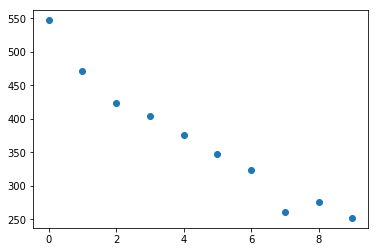

In [11]:
import matplotlib.pyplot as plot

x = range(num_epochs)
y = losses
plot.scatter(x, y)
plot.ylabel("L")

Let's try to evaluate the performance of the model we've trained. For this, we need to define a metric, a measure of model performance. `dc.metrics` holds a collection of metrics already. For this dataset, it is standard to use the ROC-AUC score, the area under the receiver operating characteristic curve (which measures the tradeoff between precision and recall). Luckily, the ROC-AUC score is already available in DeepChem. 

To measure the performance of the model under this metric, we can use the convenience function `model.evaluate()`.

In [4]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores["mean-roc_auc_score"])
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores["mean-roc_auc_score"])

Evaluating model
computed_metrics: [0.80045699830862893, 0.83618637604367374, 0.83908539936708681, 0.77873855933094183, 0.67692252993044244, 0.75578036941489168, 0.75895796821704797, 0.70234314980793855, 0.76387081283102387, 0.65924917162534913, 0.78448201448364341, 0.76675448900822296]
Training ROC-AUC Score: 0.760236
computed_metrics: [0.71533171721169553, 0.74090608465608465, 0.81106357802757933, 0.70627859684799188, 0.63177272727272715, 0.6326016835811501, 0.61491865697473169, 0.71286314850043442, 0.67676006592889104, 0.51656328658755846, 0.75414979999520937, 0.6603359173126615]
Validation ROC-AUC Score: 0.681129


What's going on under the hood? Could we build `GraphConvModel` ourselves? Of course! The first step is to create a `TensorGraph` object. This object will hold the "computational graph" that defines the computation that a graph convolutional network will perform.

In [5]:
from deepchem.models.tensorgraph.tensor_graph import TensorGraph

tg = TensorGraph(use_queue=False)

Let's now define the inputs to our model. Conceptually, graph convolutions just requires a the structure of the molecule in question and a vector of features for every atom that describes the local chemical environment. However in practice, due to TensorFlow's limitations as a general programming environment, we have to have some auxiliary information as well preprocessed.

`atom_features` holds a feature vector of length 75 for each atom. The other feature inputs are required to support minibatching in TensorFlow. `degree_slice` is an indexing convenience that makes it easy to locate atoms from all molecules with a given degree. `membership` determines the membership of atoms in molecules (atom `i` belongs to molecule `membership[i]`). `deg_adjs` is a list that contains adjacency lists grouped by atom degree For more details, check out the [code](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/mol_graphs.py).

To define feature inputs in `TensorGraph`, we use the `Feature` layer. Conceptually, a `TensorGraph` is a mathematical graph composed of layer objects. `Features` layers have to be the root nodes of the graph since they consitute inputs.

In [6]:
from deepchem.models.tensorgraph.layers import Feature

atom_features = Feature(shape=(None, 75))
degree_slice = Feature(shape=(None, 2), dtype=tf.int32)
membership = Feature(shape=(None,), dtype=tf.int32)

deg_adjs = []
for i in range(0, 10 + 1):
    deg_adj = Feature(shape=(None, i + 1), dtype=tf.int32)
    deg_adjs.append(deg_adj)

Let's now implement the body of the graph convolutional network. `TensorGraph` has a number of layers that encode various graph operations. Namely, the `GraphConv`, `GraphPool` and `GraphGather` layers. We will also apply standard neural network layers such as `Dense` and `BatchNorm`.

The layers we're adding effect a "feature transformation" that will create one vector for each molecule.

In [7]:
from deepchem.models.tensorgraph.layers import Dense, GraphConv, BatchNorm
from deepchem.models.tensorgraph.layers import GraphPool, GraphGather

batch_size = 50

gc1 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[atom_features, degree_slice, membership] + deg_adjs)
batch_norm1 = BatchNorm(in_layers=[gc1])
gp1 = GraphPool(in_layers=[batch_norm1, degree_slice, membership] + deg_adjs)
gc2 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm2 = BatchNorm(in_layers=[gc2])
gp2 = GraphPool(in_layers=[batch_norm2, degree_slice, membership] + deg_adjs)
dense = Dense(out_channels=128, activation_fn=tf.nn.relu, in_layers=[gp2])
batch_norm3 = BatchNorm(in_layers=[dense])
readout = GraphGather(
    batch_size=batch_size,
    activation_fn=tf.nn.tanh,
    in_layers=[batch_norm3, degree_slice, membership] + deg_adjs)    

Let's now make predictions from the `TensorGraph` model. Tox21 is a multitask dataset. That is, there are 12 different datasets grouped together, which share many common molecules, but with different outputs for each. As a result, we have to add a separate output layer for each task. We will use a `for` loop over the `tox21_tasks` list to make this happen. We need to add labels for each

We also have to define a loss for the model which tells the network the objective to minimize during training.

We have to tell `TensorGraph` which layers are outputs with `TensorGraph.add_output(layer)`. Similarly, we tell the network its loss with `TensorGraph.set_loss(loss)`.

In [8]:
from deepchem.models.tensorgraph.layers import Dense, SoftMax, \
    SoftMaxCrossEntropy, WeightedError, Stack
from deepchem.models.tensorgraph.layers import Label, Weights

costs = []
labels = []
for task in range(len(tox21_tasks)):
    classification = Dense(
        out_channels=2, activation_fn=None, in_layers=[readout])

    softmax = SoftMax(in_layers=[classification])
    tg.add_output(softmax)

    label = Label(shape=(None, 2))
    labels.append(label)
    cost = SoftMaxCrossEntropy(in_layers=[label, classification])
    costs.append(cost)
all_cost = Stack(in_layers=costs, axis=1)
weights = Weights(shape=(None, len(tox21_tasks)))
loss = WeightedError(in_layers=[all_cost, weights])
tg.set_loss(loss)

Now that we've successfully defined our graph convolutional model in `TensorGraph`, we need to train it. We can call `fit()`, but we need to make sure that each minibatch of data populates all four `Feature` objects that we've created. For this, we need to create a Python generator that given a batch of data generates a dictionary whose keys are the `Feature` layers and whose values are Numpy arrays we'd like to use for this step of training.

In [11]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
  for epoch in range(epochs):
    if not predict:
        print('Starting epoch %i' % epoch)
    for ind, (X_b, y_b, w_b, ids_b) in enumerate(
        dataset.iterbatches(
            batch_size, pad_batches=pad_batches, deterministic=True)):
      d = {}
      for index, label in enumerate(labels):
        d[label] = to_one_hot(y_b[:, index])
      d[weights] = w_b
      multiConvMol = ConvMol.agglomerate_mols(X_b)
      d[atom_features] = multiConvMol.get_atom_features()
      d[degree_slice] = multiConvMol.deg_slice
      d[membership] = multiConvMol.membership
      for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        d[deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
      yield d

Now, we can train the model using `TensorGraph.fit_generator(generator)` which will use the generator we've defined to train the model.

In [12]:
# Epochs set to 1 to render tutorials online.
# Set epochs=10 for better results.
tg.fit_generator(data_generator(train_dataset, epochs=1))

Starting epoch 0
Ending global_step 251: Average loss 530.84
TIMING: model fitting took 6.949 s


530.8396410260882

Now that we have trained our graph convolutional method, let's evaluate its performance. We again have to use our defined generator to evaluate model performance.

In [13]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

def reshape_y_pred(y_true, y_pred):
    """
    TensorGraph.Predict returns a list of arrays, one for each output
    We also have to remove the padding on the last batch
    Metrics taks results of shape (samples, n_task, prob_of_class)
    """
    n_samples = len(y_true)
    retval = np.stack(y_pred, axis=1)
    return retval[:n_samples]
    

print("Evaluating model")
train_predictions = tg.predict_on_generator(data_generator(train_dataset, predict=True))
train_predictions = reshape_y_pred(train_dataset.y, train_predictions)
train_scores = metric.compute_metric(train_dataset.y, train_predictions, train_dataset.w)
print("Training ROC-AUC Score: %f" % train_scores)

valid_predictions = tg.predict_on_generator(data_generator(valid_dataset, predict=True))
valid_predictions = reshape_y_pred(valid_dataset.y, valid_predictions)
valid_scores = metric.compute_metric(valid_dataset.y, valid_predictions, valid_dataset.w)
print("Valid ROC-AUC Score: %f" % valid_scores)

Evaluating model
computed_metrics: [0.83463194036351052, 0.86218739964675661, 0.84894031662657832, 0.80217986671584707, 0.70559942152332189, 0.79751934844253025, 0.8103057689046107, 0.71659210162938414, 0.80849247997327445, 0.72071717294380933, 0.83433314746710274, 0.78304357554399506]
Training ROC-AUC Score: 0.793712
computed_metrics: [0.78221936377578793, 0.78993055555555547, 0.81705388431256543, 0.77777071682765631, 0.66802272727272727, 0.67197702777122181, 0.64295604015230179, 0.72305596655628368, 0.74692724275959499, 0.63050611290902547, 0.80023473616134511, 0.73880275624461667]
Valid ROC-AUC Score: 0.732455


Success! The model we've constructed behaves nearly identically to `GraphConvModel`. If you're looking to build your own custom models, you can follow the example we've provided here to do so. We hope to see exciting constructions from your end soon!

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on GitHub
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!